In [1]:
#Importing libraries
from dbfread import DBF
import numpy as np
from skimage import data, io, filters

import tensorflow as tf
import os
import random

from tqdm import tqdm 
from zipfile import ZipFile

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from osgeo import gdal

In [2]:
#reading the test image
test_dataset = gdal.Open("D:/data/20130824_RE3_3A_Analytic_Champaign_south.tif")

In [3]:
#reading the five bands
test_red_channel = test_dataset.GetRasterBand(1).ReadAsArray()
test_green_channel = test_dataset.GetRasterBand(2).ReadAsArray()
test_blue_channel = test_dataset.GetRasterBand(3).ReadAsArray()
test_red_edge = test_dataset.GetRasterBand(4).ReadAsArray()
test_infrared_edge = test_dataset.GetRasterBand(5).ReadAsArray()

In [4]:
#stacking and min-max scaling same as training image.
img1 = np.dstack((test_red_channel, test_green_channel, test_blue_channel, test_red_edge, test_infrared_edge))
img1 = (img1 - np.min(img1)) / (np.max(img1) - np.min(img1))

In [5]:
#tiling the image, same as in the training file.
h, w, bands = img1.shape
tileSize = 128
h, w  = h//tileSize, w//tileSize


test_tiled_image = np.zeros((h*w, tileSize, tileSize, 5))

k = 0
for i in range(h):
    for j in range(w):
        test_tiled_image[k] = img1[i*tileSize : (i+1)*tileSize, j*tileSize : (j+1)*tileSize, :]
        k+=1

In [6]:
#loading my saved model
new_model = tf.keras.models.load_model('my_model.h5')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  736         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 16  0           ['conv2d_16[0][0]']              
          

In [7]:
#making predicitons
preds = new_model.predict(test_tiled_image)

105/105 [==============================] - 36s 340ms/step


In [8]:
preds.shape

(3358, 128, 128, 3)

In [9]:
#taking only the argmax to get the labels and also reshaping it to the desired output.
preds1 = np.argmax(preds, axis=-1).reshape(3358, 128, 128, 1)

In [10]:
#stitching back all the tiled images to make one final_predicted image with shape (5888, 9344, 1)
h, w, bands = img1.shape
final_image = np.zeros((128*46, 128*73, 1))
h, w = h//128, w//128
#print(final_image.shape)
k = 0
for i in range(h):
    for j in range(w):
        final_image[i*128:(i*128)+128, j*128:(j*128)+128] = preds1[k,:,:,:]
        k+=1

In [12]:
final_image.shape

(5888, 9344, 1)

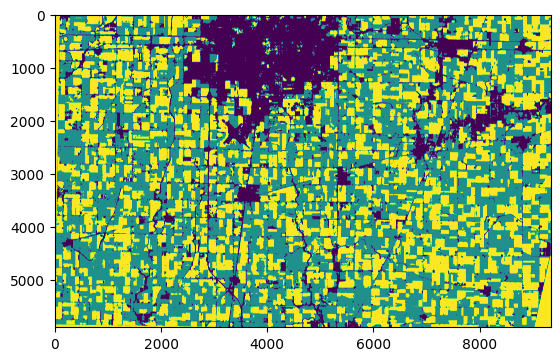

In [11]:
#plotting the final image.
plt.imshow(final_image)